# Usage

* Data [statistics](#Analysis)
* The [hinge method](#Hinge-method) : hinge statistics, sensitivity and graph, core versus tail topic distribution
* [Stability](#Common-pages-stats-and-topics-analysis) in terms of common pages 
* Future work : the case of [false positives](#Draft)

# Installing pyspark requirements

In [1]:
import os
os.environ["JAVA_HOME"] = "/lib/jvm/java-11-openjdk-amd64"
# Because otherwise custom modules import errors
#import sys
#sys.path.append('wikipedia_core_events_semantic/')
# Make directories for plots
os.makedirs('../interm_results/data_presentation', exist_ok=True)
os.makedirs('../figures_report/data_presentation', exist_ok=True)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext

import plotly.graph_objs as go
import plotly.express as px

from scipy import stats
from scipy import spatial

In [3]:
import pyspark

In [4]:
from ranking_helpers import *
from make_and_plot import*
from pages_groups_extraction import*
from data_aggregation import*

In [5]:
color_mapping = set_up_mapping()

## Initialize context 

In [6]:
conf = pyspark.SparkConf().setMaster("local[3]").setAll([
                                   ('spark.driver.memory','100G'),
                                   ('spark.executor.memory', '100G'),
                                   ('spark.driver.maxResultSize', '0'),
                                    ('spark.executor.cores', '3'),
                                    ('spark.local.dir', '/scratch/descourt/spark')
                                ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()
# create the context
sc = spark.sparkContext
sc.setLogLevel('ERROR')

23/06/20 14:01:02 WARN Utils: Your hostname, iccluster060 resolves to a loopback address: 127.0.1.1; using 10.90.39.11 instead (on interface ens786f0)
23/06/20 14:01:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/20 14:01:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/06/20 14:01:03 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


## Download data

Note : the French processed data is stored under `processed_data/fr/pageviews_fr_2015-2023.parquet`

In [7]:
dfs = spark.read.parquet("/scratch/descourt/processed_data/en/pageviews_en_2015-2023.parquet").withColumn('project', lit('en'))

In [8]:
df_topics_sp = spark.read.parquet("/scratch/descourt/metadata/akhils_data/wiki_nodes_topics_2022-09.parquet")
def find_topic_specific(topics):
    not_starred = [t for t in topics if not '*' in t]
    if len(not_starred) == 0:
        return topics[0]
    else:
        return not_starred[0]
find_topic_specific_udf = udf(find_topic_specific)
df_topics_sp = df_topics_sp.where('wiki_db = "enwiki" AND score >= "0.5"')\
                          .select('page_id', 'topic', col('score').cast('float'))\
                          .groupBy('page_id')\
                          .agg(sort_array(collect_list(struct("score", "topic")), asc=False).alias("topicsList"))\
                          .select('page_id', col('topicsList.topic').alias('topics'), find_topic_specific_udf(col('topicsList.topic')).alias('topic')).cache()

## Process data

## Volumes using the hinge method

In [9]:
df_high_volume = extract_volume(dfs, high=True).cache()

In [10]:
df_low_volume = extract_volume(dfs, high=False).cache()

## Topics

### How much data are we loosing ?

In [11]:
df_low_volume_augm = df_low_volume.join(df_topics_sp.select('page_id', 'topic').distinct(), 'page_id').cache()

In [12]:
df_high_volume_augm= df_high_volume.join(df_topics_sp.select('page_id', 'topic').distinct(), 'page_id').cache()

In [ ]:
df_high_nb = df_high_volume.groupBy('date').agg(count('*').alias('nb_pages')).toPandas()
df_high_matched = df_high_volume_augm.groupBy('date').agg(count('*').alias('nb_pages')).toPandas()

df_low_nb = df_low_volume.groupBy('date').agg(count('*').alias('nb_pages')).toPandas()
df_low_matched = df_low_volume_augm.groupBy('date').agg(count('*').alias('nb_pages')).toPandas()

In [ ]:
df_high_nb  = df_high_nb.merge(df_high_matched.rename(columns={'nb_pages' : 'matched_pages'}), on='date')
df_high_nb['loss'] = (df_high_nb['nb_pages'] - df_high_nb['matched_pages']) / df_high_nb['nb_pages'] * 100
df_high_nb

In [ ]:
df_low_nb  = df_low_nb.merge(df_low_matched.rename(columns={'nb_pages' : 'matched_pages'}), on='date')
df_low_nb['loss'] = (df_low_nb['nb_pages'] - df_low_nb['matched_pages']) / df_low_nb['nb_pages'] * 100
df_low_nb

In [23]:
df_high_nb.describe()

,nb_pages,matched_pages,loss
count,93.000000,93.000000,93.000000
mean,666365.946237,648011.290323,2.788023
std,48834.743017,50501.099306,0.517438
min,571454.000000,550657.000000,1.934505
25%,629444.000000,609316.000000,2.333239
50%,676710.000000,660913.000000,2.841196
75%,711249.000000,694324.000000,3.187130
max,742619.000000,728253.000000,3.742929


In [24]:
df_low_nb.describe()

,nb_pages,matched_pages,loss
count,9.300000e+01,9.300000e+01,93.000000
mean,5.112272e+06,4.889142e+06,4.437253
std,4.690716e+05,4.889997e+05,0.847967
min,4.251693e+06,4.022272e+06,3.049510
25%,4.731677e+06,4.484628e+06,3.748308
50%,5.130459e+06,4.898374e+06,4.517165
75%,5.521277e+06,5.311584e+06,5.221172
max,5.866158e+06,5.650129e+06,5.727273


### Matching topics

In [52]:
df_low_volume_top = df_low_volume.join(df_topics_sp.select('page_id', 'topic').distinct(), 'page_id')\
                               .groupBy('date', 'topic')\
                               .agg(count('*').alias('nb_pages'))\
                               .toPandas()

In [53]:
df_high_volume_top= df_high_volume.join(df_topics_sp.select('page_id', 'topic').distinct(), 'page_id')\
                               .groupBy('date', 'topic').agg(count('*').alias('nb_pages')).toPandas()

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [54]:
df_top = dfs.join(df_topics_sp.select('page_id', 'topic').distinct(), 'page_id')\
                               .groupBy('date', 'topic')\
                               .agg(count('*').alias('nb_pages'))\
                               .toPandas()

# Analysis

## Exploring volume of page views - English edition

In [55]:
import pyspark.sql.functions as f

# Make stats
stats_views = dfs.groupBy('date').agg(max('tot_count_views').alias('max'),\
                                      min('tot_count_views').alias('min'),\
                                      f.percentile_approx('tot_count_views', 0.5).alias('med'),\
                                      f.percentile_approx('tot_count_views', 0.25).alias('25%'),\
                                      f.percentile_approx('tot_count_views', 0.75).alias('75%'),\
                                      f.percentile_approx('tot_count_views', 0.9).alias('90%'),\
                                      avg('tot_count_views').alias('avg'),\
                                      sum('tot_count_views').alias('sum'),
                                      count("*").alias('nb_pages')).toPandas()

In [11]:
# Describe general statistics
stats_views.describe()

,max,min,med,25%,75%,90%,avg,sum,nb_pages
count,9.300000e+01,93.0,93.000000,93.000000,93.000000,93.000000,93.000000,9.300000e+01,9.300000e+01
mean,1.426850e+07,1.0,78.698925,25.064516,337.483871,1493.591398,1209.302438,6.944552e+09,5.778638e+06
std,1.998756e+07,0.0,15.448924,7.573992,45.179981,159.928193,106.235662,4.002355e+08,5.162870e+05
min,4.432041e+06,1.0,54.000000,14.000000,255.000000,1195.000000,1001.378291,6.335172e+09,4.825050e+06
25%,7.351679e+06,1.0,62.000000,17.000000,295.000000,1368.000000,1141.514900,6.673898e+09,5.361052e+06
50%,9.541524e+06,1.0,83.000000,26.000000,347.000000,1498.000000,1197.212654,6.859175e+09,5.810444e+06
75%,1.356249e+07,1.0,88.000000,29.000000,368.000000,1601.000000,1282.356701,7.142078e+09,6.238301e+06
max,1.461972e+08,1.0,120.000000,48.000000,429.000000,1803.000000,1464.380552,8.686724e+09,6.578424e+06


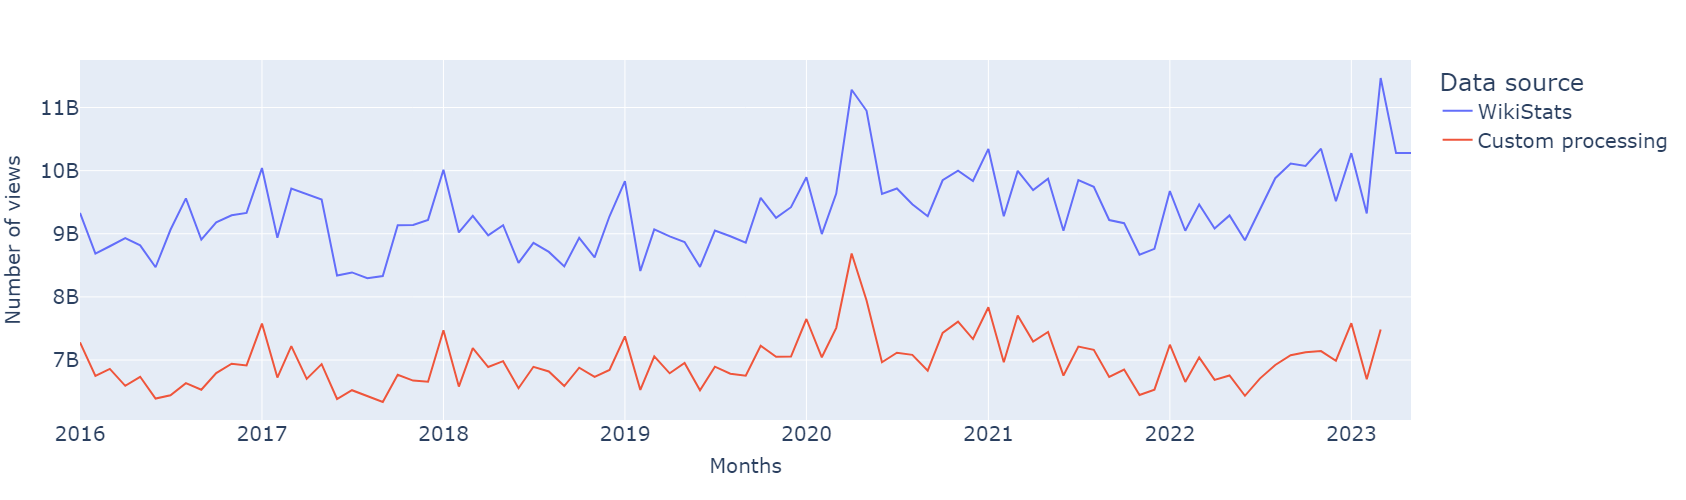

In [56]:
# NUmber of total views English edition gathers per months. The high peak around is due to false positive, 
# ie. a given random page which was accessed loaaaads of time 
wiki_stats_views = pd.read_csv("../data/WikiStats_views_En.csv")
wiki_stats_views.rename(columns={'month':'date', 'total.total':'tot_views'}, inplace=True)
wiki_stats_views['date'] = wiki_stats_views['date'].apply(lambda l : '-'.join(l.split('-')[:2]))
wiki_stats_views = wiki_stats_views.groupby('date').agg(tot_views=('tot_views', 'sum')).reset_index()
our_views = stats_views[~stats_views.date.isin([f'{y}-{m}' for y in ['2015'] for m in [f'0{i}' if i < 10 else i for i in range(7, 13, 1)]])].sort_values('date')[['date', 'sum']].rename(columns={'sum' : 'tot_views'})
our_views['Data source'] = 'Custom processing'
wiki_stats_views['Data source'] = 'WikiStats'

df_plot = pd.concat([wiki_stats_views, our_views])

# Plot
fig = px.line(df_plot.sort_values('date'), x='date', y = 'tot_views', color='Data source', log_y=False)
fig.update_layout(
    xaxis_title=dict(text='Months', font=dict(size=20)),
    yaxis_title=dict(text='Number of views', font=dict(size=20)),
    yaxis = dict( tickfont = dict(size=20)),
    xaxis = dict( tickfont = dict(size=20)),
    height=500,
    width=800,
    legend= dict( font = dict(size=20)),
    barmode='group'
)

fig.show()
fig.write_image("../figures_report/Methods_and_Data/number_of_views.pdf")

In [99]:
# For later analysis
nb_pages_all = dfs.groupBy('date').agg(count("*").alias('nb_pages')).toPandas()

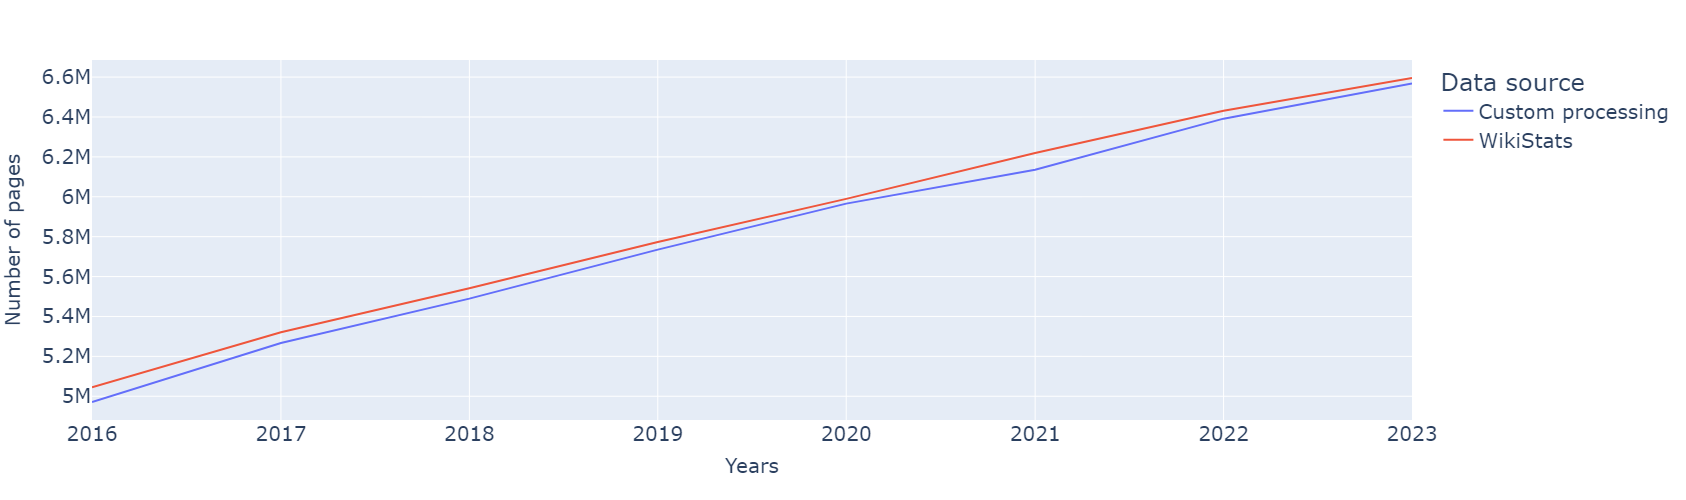

In [114]:
# Prepare data for plotting
stats_views['is_Jan'] = stats_views['date'].apply(lambda d : '-01' in d)
stats_views['Data source'] = 'Custom processing'

# Stats taken from https://en.wikipedia.org/wiki/Wikipedia:Size_of_Wikipedia#:~:text=As%20of%2010%20June%202023,of%20all%20pages%20on%20Wikipedia.
wiki_stats = pd.DataFrame({
'date': ['2016-01', '2017-01', '2018-01', '2019-01', '2020-01', '2021-01', '2022-01', '2023-01'],
'nb_pages' : [5045000, 5321200, 5541900, 5773600, 5989400, 6219700, 6431400,6595468],
'Data source' : ['WikiStats', 'WikiStats', 'WikiStats', 'WikiStats', 'WikiStats', 'WikiStats', 'WikiStats', 'WikiStats']})
nb_pages = pd.concat([stats_views[stats_views['is_Jan']][['date', 'nb_pages', 'Data source']], wiki_stats])

# Plot
fig = px.line(nb_pages.sort_values('date'), x='date', y = 'nb_pages', color='Data source', log_y=False)
fig.update_layout(
    xaxis_title=dict(text='Years', font=dict(size=20)),
    yaxis_title=dict(text='Number of pages', font=dict(size=20)),
    yaxis = dict( tickfont = dict(size=20)),
    xaxis = dict( tickfont = dict(size=20)),
    height=500,
    width=800,
    legend= dict( font = dict(size=20))
)

fig.show()
fig.write_image("../figures_report/Methods_and_Data/number_of_pages.pdf")

In [104]:
percentage_matched = (nb_pages.sort_values('date').loc[nb_pages['Data source'] == 'Custom processing','nb_pages'].values / nb_pages.sort_values('date').loc[nb_pages['Data source'] == 'WikiStats','nb_pages'].values)

In [105]:
print(percentage_matched.mean(), percentage_matched.std() * 1.96 / np.sqrt(2023 - 2016 + 1))

0.9913851939882259 0.002621666769839844


### Looking at first top pages, whether they are "false positive" or not

Have a look [here](https://pageviews.wmcloud.org/topviews/faq/#false_positive) to know more about false positive !

In [35]:
w = Window.partitionBy('date').orderBy(desc('tot_count_views'))
df_fp = dfs.where('rank < 5').toPandas()

In [42]:
df_fp[df_fp.date.isin(['2020-02', '2020-03'])]

,date,tot_count_views,page_id,page,rank,fractional_rank
66,2020-03,8772504.0,63030231,Coronavirus_disease_2019,4,4.0
97,2020-03,11220851.0,201983,Coronavirus,3,3.0
104,2020-03,31923356.0,62750956,2019–20_coronavirus_pandemic,2,2.0
167,2020-02,8996282.0,62750956,2019–20_Wuhan_coronavirus_outbreak,3,3.0
179,2020-03,132769714.0,24909346,United_States_Senate,1,1.0
191,2020-02,14077383.0,5043734,Wikipedia,2,2.0
241,2020-02,146197239.0,24909346,United_States_Senate,1,1.0
323,2020-02,8298748.0,56746570,Parasite_(2019_film),4,4.0


### Zipf's distribution for number of pageviews vs rank plot

In [54]:
df_distrib_plot = dfs.where(dfs.rank.isin([1, 10, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 3000000, 5000000])).select('date', 'tot_count_views', 'rank').toPandas()

In [58]:
df_distrib_plot_agg = df_distrib_plot.groupby('rank').agg(avg=('tot_count_views', 'mean'), std=('tot_count_views', 'std')).reset_index()
df_distrib_plot_agg['error'] = df_distrib_plot_agg['std'] * 1.96 / np.sqrt(93)

In [91]:
df_distrib_plot_agg['Data'] = 'Wikipedia'
df_baseline = pd.DataFrame({'rank': [1, 10, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 3000000, 5000000],
                            'avg': 1.5*10**7 / np.sqrt([1, 10, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 3000000, 5000000])})
df_baseline['Data'] = '$x^{-1/2}$'
df_baseline['error'] = 0

df_baseline_2 = df_baseline.copy()
df_baseline_2['Data'] = '$x^{-2/3}$'
df_baseline_2['avg'] = 1.5*10**7 * np.array([1, 10, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 3000000, 5000000]) ** (-1/1.5)
df_plot = pd.concat([df_distrib_plot_agg, df_baseline, df_baseline_2])

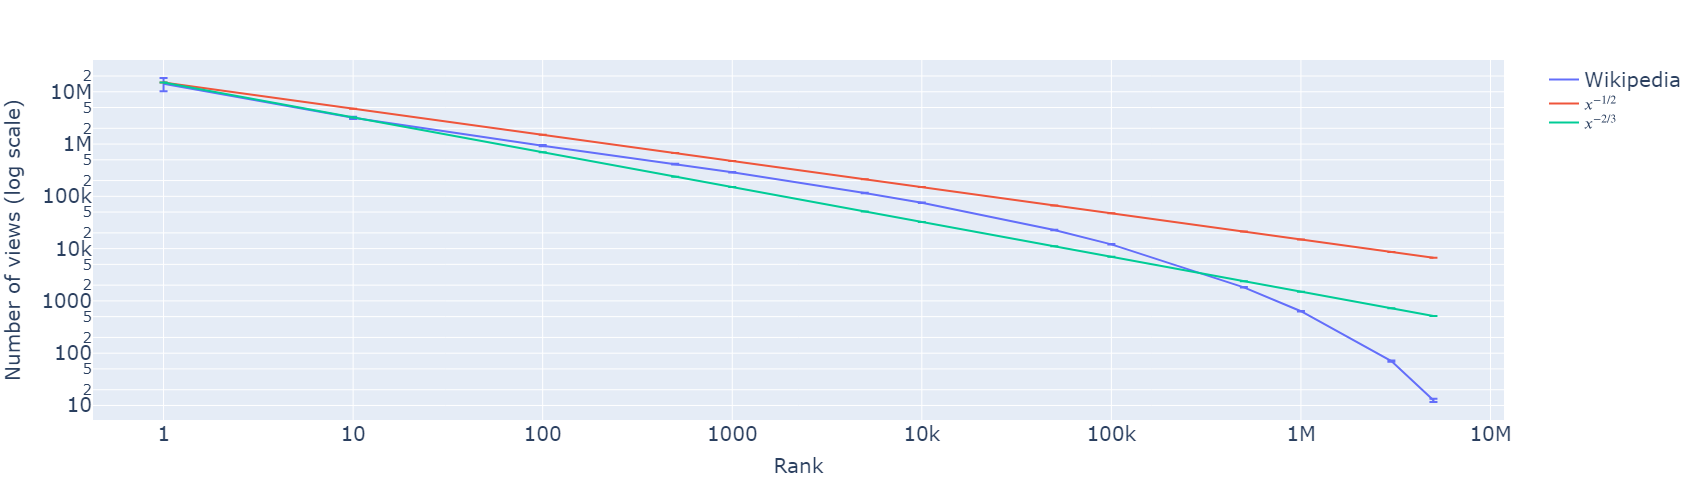

In [115]:
fig = px.line(df_plot.sort_values('rank'), x='rank', y='avg', color='Data',log_y=True, log_x=True, error_y='error')
fig.update_layout(
xaxis_title=dict(text='Rank', font=dict(size=20)),
yaxis_title=dict(text='Number of views (log scale)', font=dict(size=20)),
height=500,
width=800,
    legend= dict( font = dict(size=20), title=None),
    yaxis = dict( tickfont = dict(size=20)),
    xaxis = dict( tickfont = dict(size=20)),)
fig.show()

fig.write_image("../figures_report/Methods_and_Data/rank_distrib_log.pdf")

# Cut-off analysis

## Hinge method

### Hinge analysis

#### Plot

In [76]:
df_cutoff = compute_volumes(dfs)
df_hinge = find_hinge_point(df_cutoff).cache()

In [81]:
df_hinge.describe().show()

+-------+-------+-------+-----------------+-------------------+
|summary|project|   date|       hinge_perc|         hinge_rank|
+-------+-------+-------+-----------------+-------------------+
|  count|     93|     93|               93|                 93|
|   mean|   null|   null|88.13948197530003| 11.550006426831215|
| stddev|   null|   null|0.640549160796781|0.28705815823939196|
|    min|     en|2015-07|86.56392307302383| 10.827304533730267|
|    max|     en|2023-03|89.22312834942161| 12.092430289662587|
+-------+-------+-------+-----------------+-------------------+



In [78]:
df_cutoff_agg = df_cutoff.where((col('rank') % 50) == 0).groupBy('perc_rank').agg(avg('perc_views').alias('perc_views'),\
                                                                                  (stddev('perc_views') * 1.96 / np.sqrt(93)).alias('error_views')).toPandas()

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [79]:
df_cutoff_agg = df_cutoff_agg.sort_values('perc_rank', ascending=True)

In [80]:
hinge_points = df_hinge.select(avg('hinge_perc').alias('avg_views'), stddev('hinge_perc').alias('std_views'),
                              avg('hinge_rank').alias('avg_rank'), stddev('hinge_rank').alias('std_rank')).collect()
hinge_point = [hinge_points[0]['avg_views'], hinge_points[0]['avg_rank']]

In [104]:
def make_cumulative_plot(df, hinge_point, path=None):    
    fig =go.Figure()
    fig.add_traces(
        go.Scatter(
            x=[hinge_point[1], hinge_point[1]],
            y=[0, 100],
            mode="lines",
            line=go.scatter.Line(color="green"),
            name=f"{np.round(hinge_point[0]*100)/ 100} % of views")
    )
    fig.add_traces(
        go.Scatter(
            y=[hinge_point[0], hinge_point[0]],
            x=[0, 100],
            mode="lines",
            line=go.scatter.Line(color="red"),
            name=f"{np.round(hinge_point[1]*100)/ 100} % of ranks")
    )
    fig.add_traces(
        go.Scatter(
            y=df['perc_views'].values,
            x=df['perc_rank'].values,
            mode="lines",
            line=go.scatter.Line(color="blue"),
            name=f"Cumulated views",
                error_y=dict(
                type='data', # value of error bar given in data coordinates
            array=df['error_views'].values,
            visible=True)
    ))
    fig.update_layout(
        xaxis_title=dict(text='Cumulated ranks in %', font=dict(size=20)),
        yaxis_title=dict(text='Cumulated views in %', font=dict(size=20)),
        height=600,
        width=800,
    legend= dict( font = dict(size=20), title=None),
    yaxis = dict( tickfont = dict(size=20)),
    xaxis = dict( tickfont = dict(size=20)),)
    
    fig.show()
    if path is not None:
        fig.write_image(path)

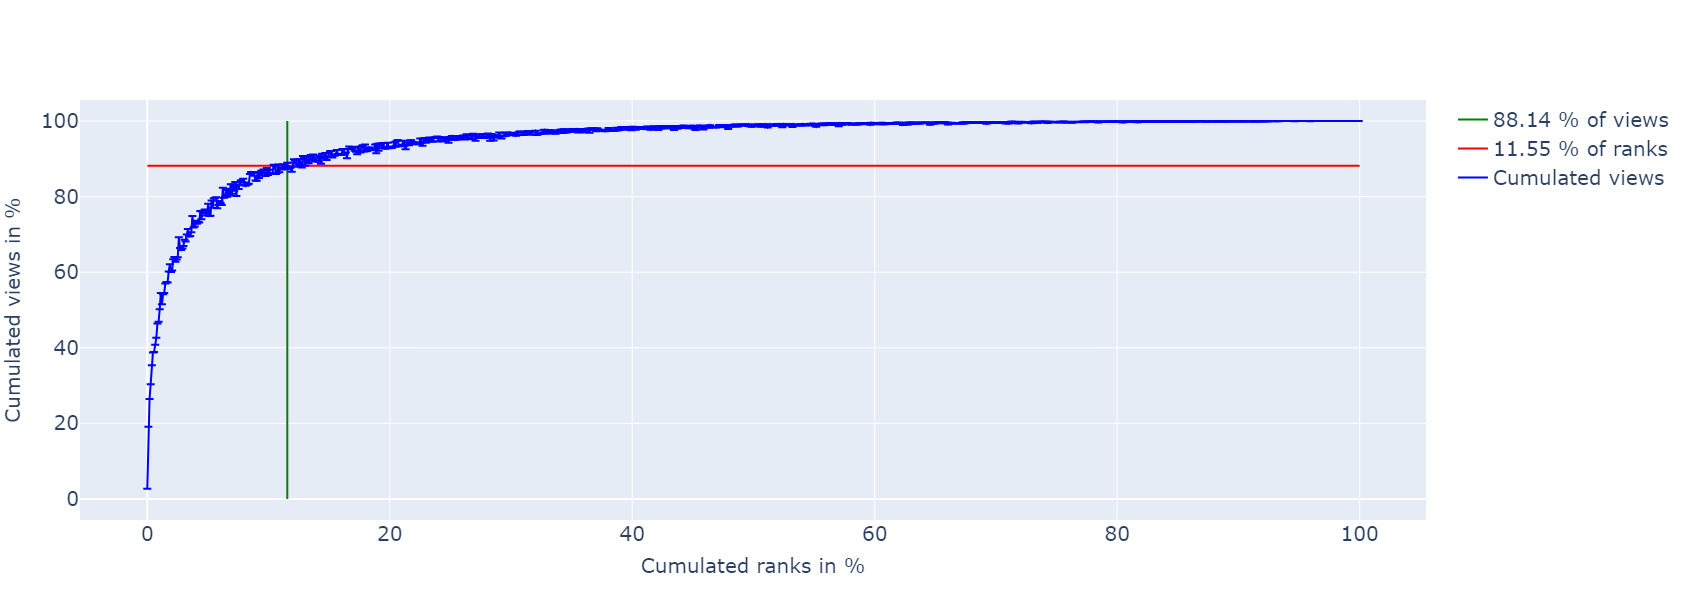

(None,)

In [105]:
make_cumulative_plot(df_cutoff_agg.iloc[::10000,:], hinge_point,path="../figures_report/data_presentation/hinge_en.pdf"),

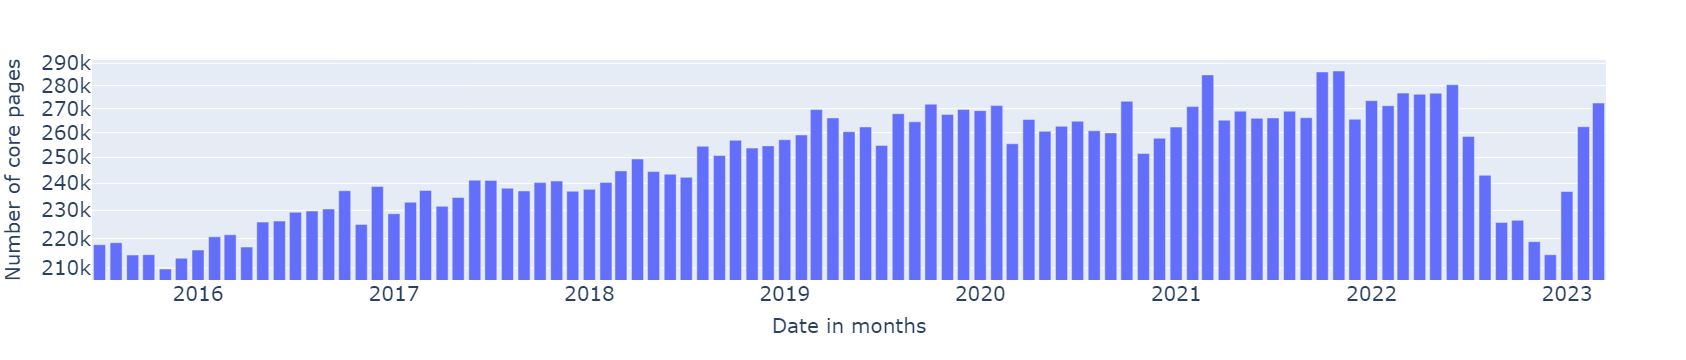

In [154]:
df_hinge_pd = df_hinge.toPandas()
df_hinge_pd = df_hinge_pd.merge(nb_pages_all[['date', 'nb_pages']], on='date')
df_hinge_pd['core_pages'] = df_hinge_pd['hinge_rank']*df_hinge_pd['nb_pages']
df_hinge_pd['core_pages'] = df_hinge_pd['hinge_rank']*df_hinge_pd['nb_pages'] / 100
fig = px.bar(df_hinge_pd.sort_values('date'), x='date', y = 'core_pages', log_y=True)
fig.update_layout(
    xaxis_title=dict(text='Date in months', font=dict(size=20)),
    yaxis_title=dict(text='Number of core pages', font=dict(size=20)),
    yaxis = dict( tickfont = dict(size=20)),
    xaxis = dict( tickfont = dict(size=20)))
fig.show()
fig.write_image("../figures_report/data_presentation/core_pages_fr.pdf")

#### Hinge stats

Sampling the dataset and looking at how hinge varies in the y-axis = Sensitivity analysis

In [138]:
stats = []

for sampling_step in tqdm([1,5,50,100,300, 700, 1000]):
    df_cutoff = compute_volumes(dfs, sampling=sampling_step)
    df_hinge = find_hinge_point(df_cutoff)
    df_hinge_pd = df_hinge.toPandas().describe()
    df_hinge_pd = df_hinge_pd.reset_index().rename(columns={'hinge_perc' : f'hinge_perc_{sampling_step}', 'hinge_rank' : f'hinge_rank_{sampling_step}'})
    stats.append(df_hinge_pd)

100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:20<00:00, 11.44s/it]


In [ ]:
spark.catalog.clearCache()

In [139]:
stats_eps = []
df_cutoff = compute_volumes(dfs, sampling=1).cache()
for eps in tqdm([1, 0.5, 0.1, 0.05, 0.01, 0.001]):
    df_hinge = find_hinge_point(df_cutoff, eps=eps)
    df_hinge_pd = df_hinge.toPandas().describe()
    df_hinge_pd = df_hinge_pd.reset_index().rename(columns={'hinge_perc' : f'hinge_perc_{eps}', 'hinge_rank' : f'hinge_rank_{eps}'})
    stats_eps.append(df_hinge_pd)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [10:22<00:00, 103.76s/it]


In [140]:
from functools import reduce
def merge_on(df1, df2):
    
    return df1.merge(df2, on='index')

stats_rev = [df.set_index('index') for df in stats]
stats_eps_rev = [df.set_index('index') for df in stats_eps]
stats_df = reduce(merge_on, stats_rev)
stats_eps_df = reduce(merge_on, stats_eps_rev)

In [141]:
stats_df = stats_df.T.reset_index(names='sampling_step')
stats_df['Percentage'] = stats_df.apply(lambda r: 'Ranks' if 'rank' in r.sampling_step else 'Views', axis=1)
stats_df['s'] = stats_df.apply(lambda r: r.sampling_step.split('_')[-1], axis=1)

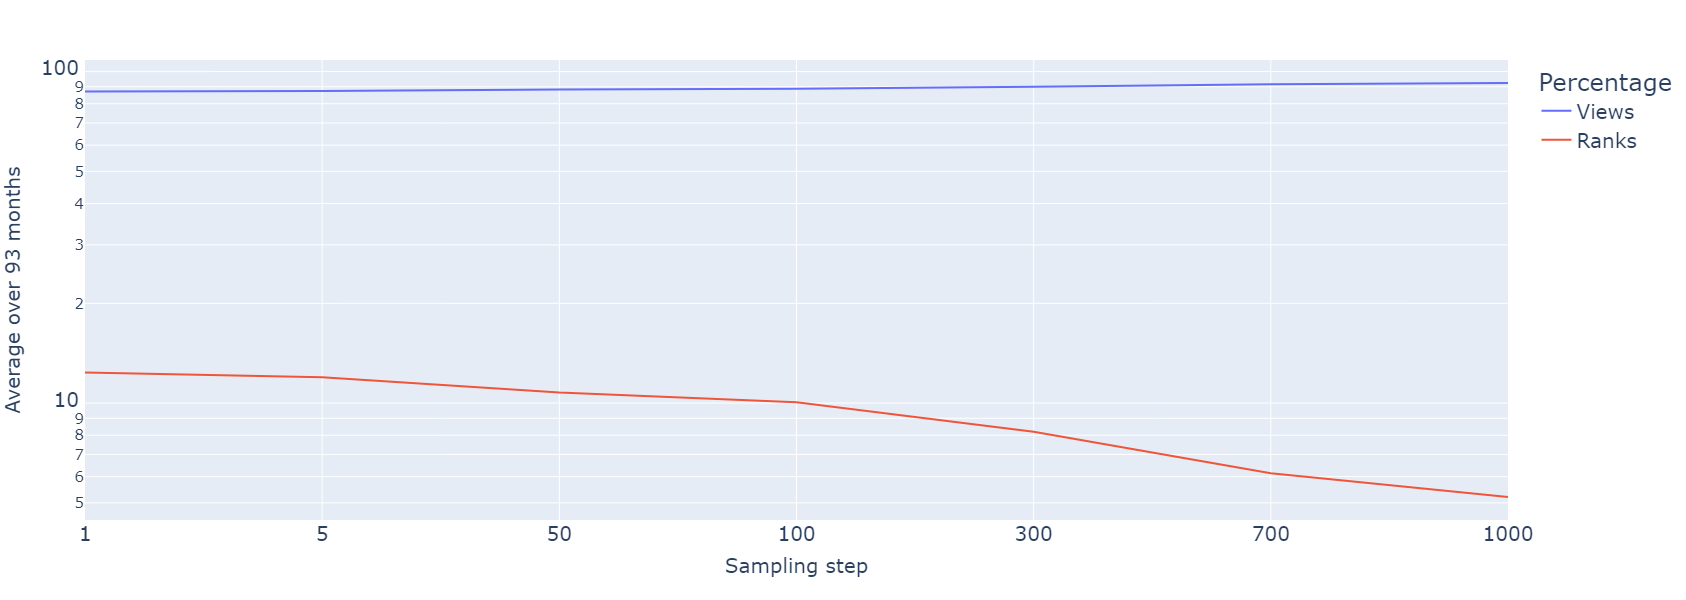

In [142]:
fig = px.line(stats_df.rename(columns={'mean': 'Average over 93 months', 's':'Sampling step'}), x = 'Sampling step', color='Percentage', y='Average over 93 months', log_y=True)
fig.update_layout(
    xaxis_title=dict(font=dict(size=20)),
    yaxis_title=dict(font=dict(size=20)),
    yaxis = dict( tickfont = dict(size=20)),
    xaxis = dict( tickfont = dict(size=20)),
legend=dict(font=dict(size=20)),
height=600,
width=600)
fig.show()
fig.write_image("../figures_report/data_presentation/sens_sampling_en.pdf")

In [143]:
stats_eps_df = stats_eps_df.T.reset_index(names='slope')
stats_eps_df['Percentage'] = stats_eps_df.apply(lambda r: 'Ranks' if 'rank' in r.slope else 'Views', axis=1)
stats_eps_df['s'] = stats_eps_df.apply(lambda r: r.slope.split('_')[-1], axis=1)

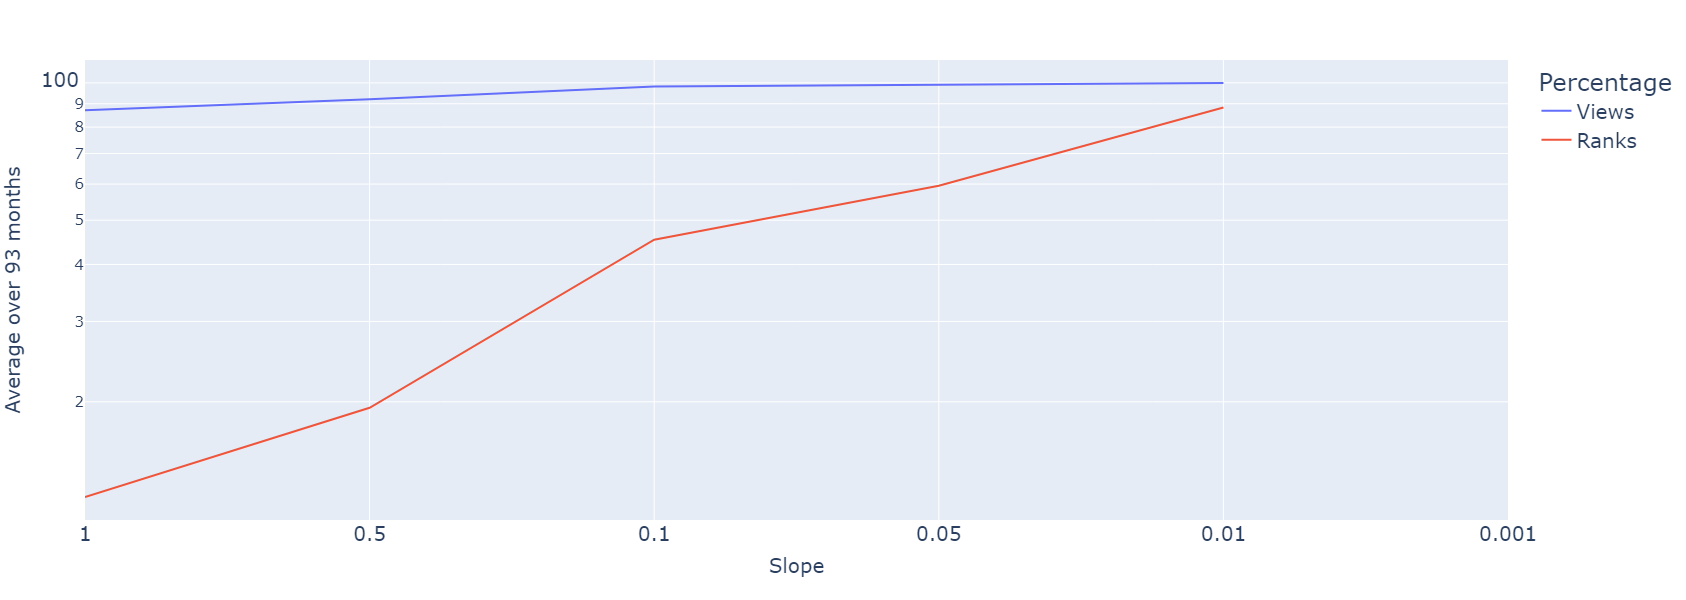

In [144]:
fig = px.line(stats_eps_df.rename(columns={'mean': 'Average over 93 months', 's' : 'Slope'}), x = 'Slope', color='Percentage', y='Average over 93 months', log_y=True)
fig.update_layout(
    xaxis_title=dict(font=dict(size=20)),
    yaxis_title=dict(font=dict(size=20)),
    yaxis = dict( tickfont = dict(size=20)),
    xaxis = dict( tickfont = dict(size=20)),
legend=dict(font=dict(size=20)),
height=600,
width=600)
fig.show()
fig.write_image("../figures_report/data_presentation/sens_slope_em.pdf")

In [91]:
def show_sensitivity(df, stats, path=None):
    
    plt.figure()
    samplings = [col.split('_')[-1] for col in stats.columns if 'perc' in col]
    means_perc = stats[[col for col in stats.columns if 'perc' in col]].loc['mean'].values
    means_rank = stats[[col for col in stats.columns if 'rank' in col]].loc['mean'].values
    df.rename(columns={'perc_views' : 'Cumulative Views'}).drop('error_views', axis=1).set_index('perc_rank').plot(figsize=(15,10), legend=False)
    for s, mp, mr, c in zip(samplings, means_perc, means_rank, ['b', 'g', 'r', 'magenta', 'yellow', 'orange', 'black']):
        plt.axhline(mp, c=c, xmin=mr*0.01)
        plt.axvline(mr, c=c, label=f'{np.round(mp)}% - {np.round(mr)}% s:{s}', ymax=mp*0.01)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Percentage of total pages', fontsize=20)
    plt.ylabel('Cumulative percentage of pageviews monthly volume', fontsize=20)
    plt.xlim([0, 100])
    plt.ylim([0, 100])
    plt.show()
    
    if path is not None:
        plt.savefig(path)
        
    

In [145]:
from functools import reduce
def merge_on(df1, df2):
    
    return df1.merge(df2, on='index')

stats_rev = [df.set_index('index') for df in stats]
stats_eps_rev = [df.set_index('index') for df in stats_eps]
stats_df = reduce(merge_on, stats_rev)
stats_eps_df = reduce(merge_on, stats_eps_rev)

<Figure size 640x480 with 0 Axes>

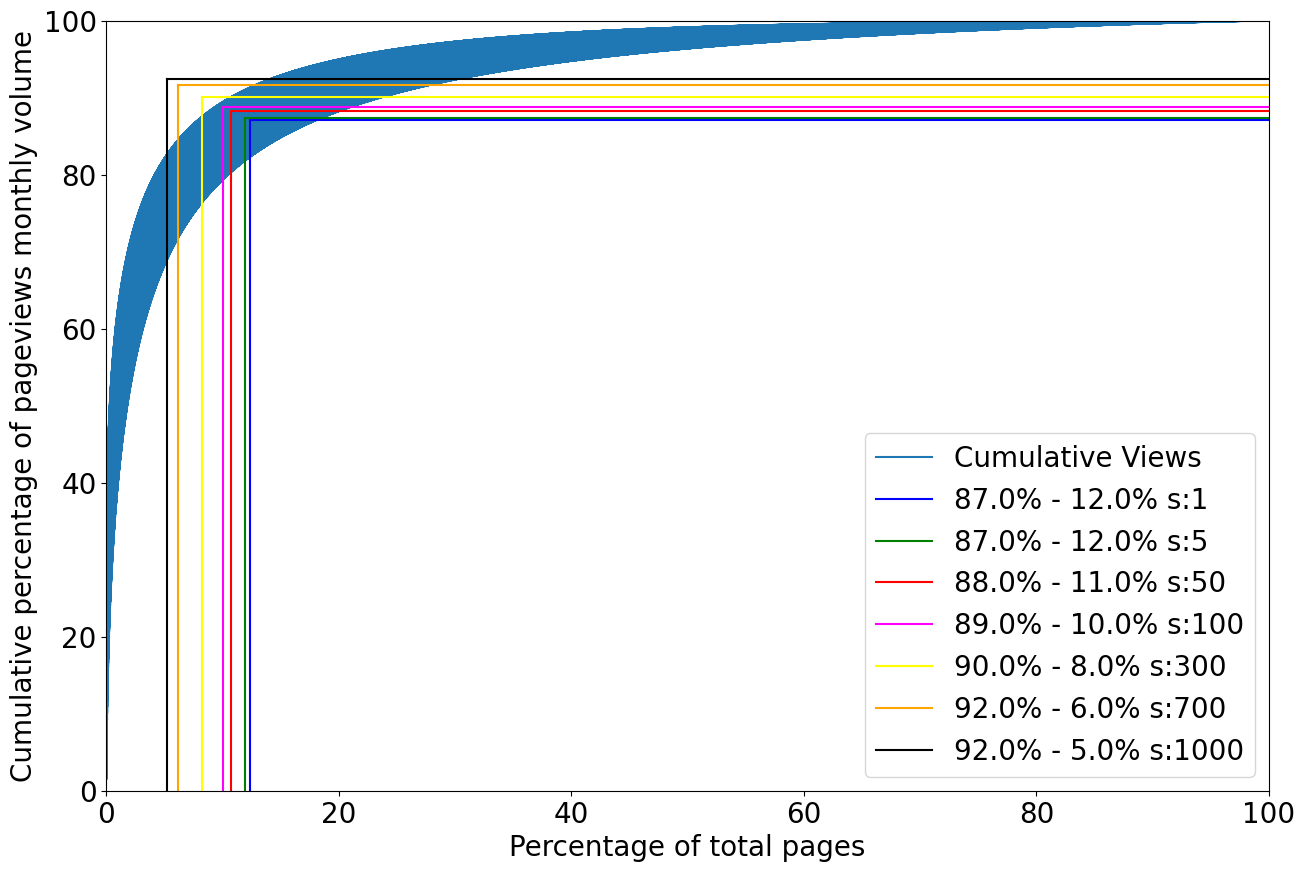

<Figure size 640x480 with 0 Axes>

In [146]:
show_sensitivity(df_cutoff_agg, stats_df, path="../figures_report/data_presentation/hinge_sampling_fr.pdf")

<Figure size 640x480 with 0 Axes>

/home/descourt/.conda/envs/wiki_sem/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



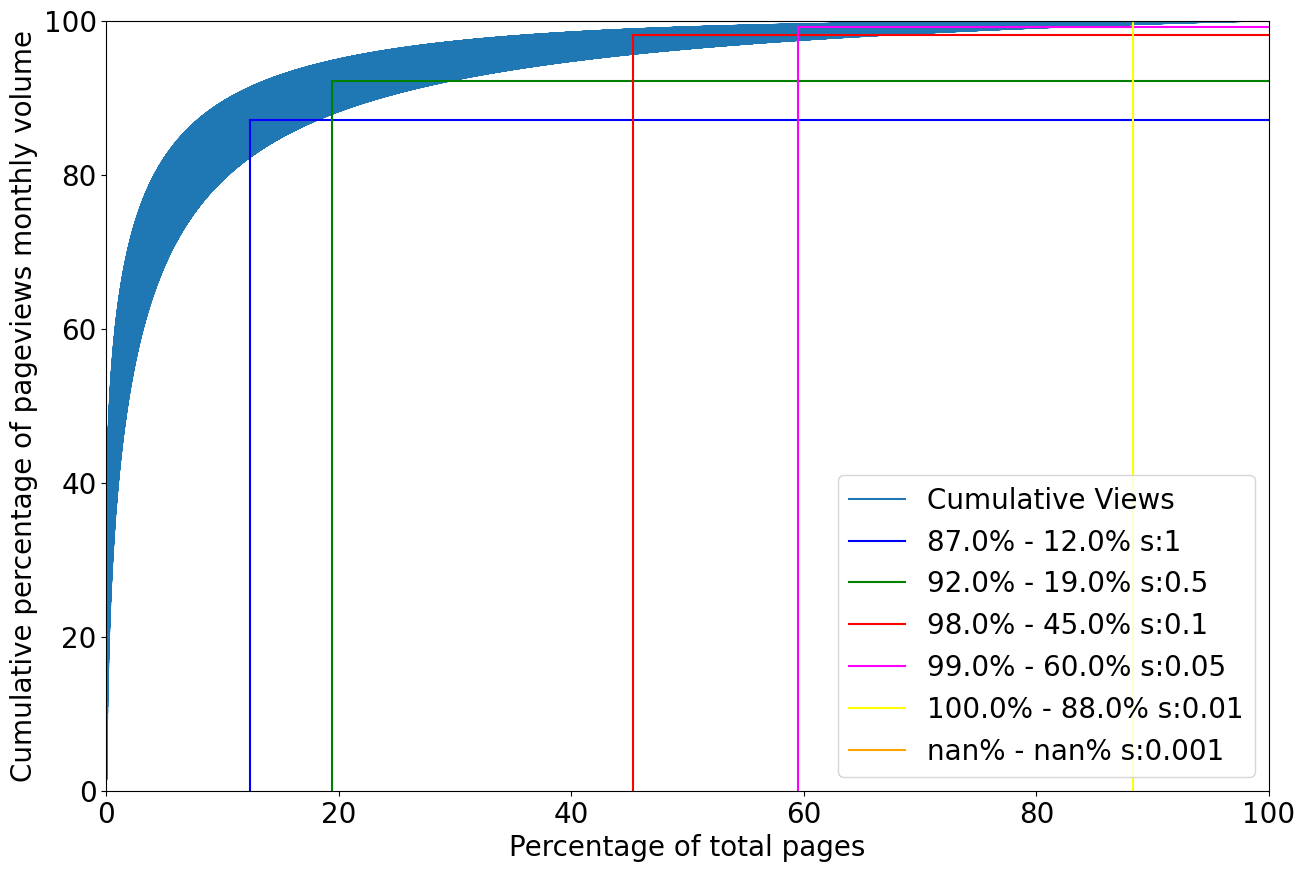

<Figure size 640x480 with 0 Axes>

In [147]:
show_sensitivity(df_cutoff_agg, stats_eps_df, path="../figures_report/data_presentation/hinge_eps_fr.pdf")

## Common maximisation

Maximise for the common percentage across the studied period in the two split volumes, which would end up being a core and a tail, 
but based on the maximised amount of stable pages within each. But circular definition

In [28]:
top_ns =  [i for i in range(7*10**5, 9*10**5, 5*10**4)]
means = []

for n in tqdm(top_ns):

    df_top_n =  dfs.where(f'rank <= "{n}"').cache()
    df_agg = df_top_n.groupBy('page_id').agg(count('*').alias('nb_occurrences')).cache()
    nb_common = df_agg.where(f'nb_occurrences = "93"').select('page_id').distinct().count()
    if n < 10**6 :
        nb_per_months = n 
    else :
        nb_per_months = df_top_n.groupBy('date').agg(count('*').alias('nb_pages_monthly')).select(avg('nb_pages_monthly').alias('avg')).collect()[0]['avg']
        
    means.append(nb_common / nb_per_months)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [10:07<00:00, 151.93s/it]


In [32]:
means_tail = []
stds_tail = []

for n in tqdm(top_ns):

    df_top_n =  dfs.where(f'rank >= "{n}"').cache()
    df_agg = df_top_n.groupBy('page_id').agg(count('*').alias('nb_occurrences')).cache()
    nb_common = df_agg.where(f'nb_occurrences = "93"').select('page_id').distinct().count()
    nb_per_months = df_top_n.groupBy('date').agg(count('*').alias('nb_pages_monthly'))
    prop_tot = nb_per_months.withColumn('prop_month', nb_common / col('nb_pages_monthly') * 100)\
                            .select(avg('prop_month').alias('avg'), stddev('prop_month').alias('std'))\
                            .collect()
    means_tail.append(prop_tot[0]['avg'])
    stds_tail.append(prop_tot[0]['std'])

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out  | 1/4 [04:20<13:00, 260.06s/it]
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [28:57<00:00, 434.29s/it]


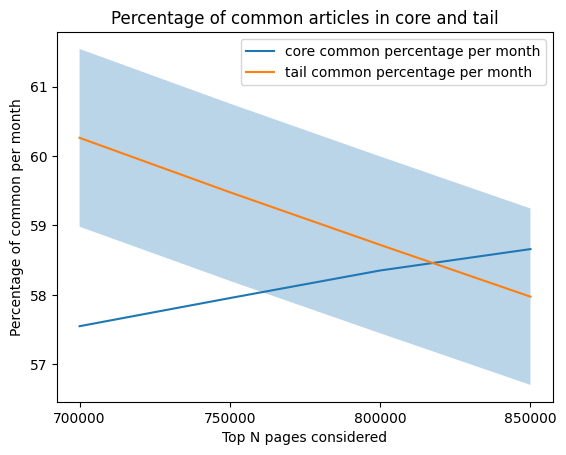

In [34]:
means = np.array(means) / 100
means_tail = np.array(means_tail)
stds_tail = np.array(stds_tail)
plt.figure()
plt.plot(means, label='core common percentage per month')
plt.fill_between(range(len(means_tail)), means_tail + 1.96*stds_tail / np.sqrt(93), 
                 means_tail - 1.96*stds_tail / np.sqrt(93),
                alpha=0.3)
plt.plot(means_tail, label='tail common percentage per month')
plt.xticks(range(0,len(top_ns)), labels=top_ns)
plt.title('Percentage of common articles in core and tail')
plt.legend()
plt.xlabel('Top N pages considered')
plt.ylabel('Percentage of common per month')
plt.show()

## Volumes comparison

Between the core and the tail, volume distribution comparison

In [57]:
def make_perc(df, t='tail'):
    tot_pages = df.groupby('date').agg(sum_pages=('nb_pages','sum')).reset_index()
    df = df.merge(tot_pages, on='date')
    df['perc_pages'] = df['nb_pages'] / df['sum_pages'] * 100
    df_res = df.groupby('topic').agg(mean=('perc_pages', 'mean'), std=('perc_pages', 'std'))
    df_res['Volume'] = t
    return df_res

In [58]:
df_low_volume_top_agg = make_perc(df_low_volume_top, t='Tail').sort_values('topic')
df_high_volume_top_agg = make_perc(df_high_volume_top, t='Core').sort_values('topic')
df_top_agg = make_perc(df_top, t='Entire Volume').sort_values('topic')

In [59]:
df_plot = pd.concat([df_low_volume_top_agg, df_high_volume_top_agg, df_top_agg]).reset_index()

In [60]:
df_plot['error'] = df_plot['std'] * 1.96 / np.sqrt(93)

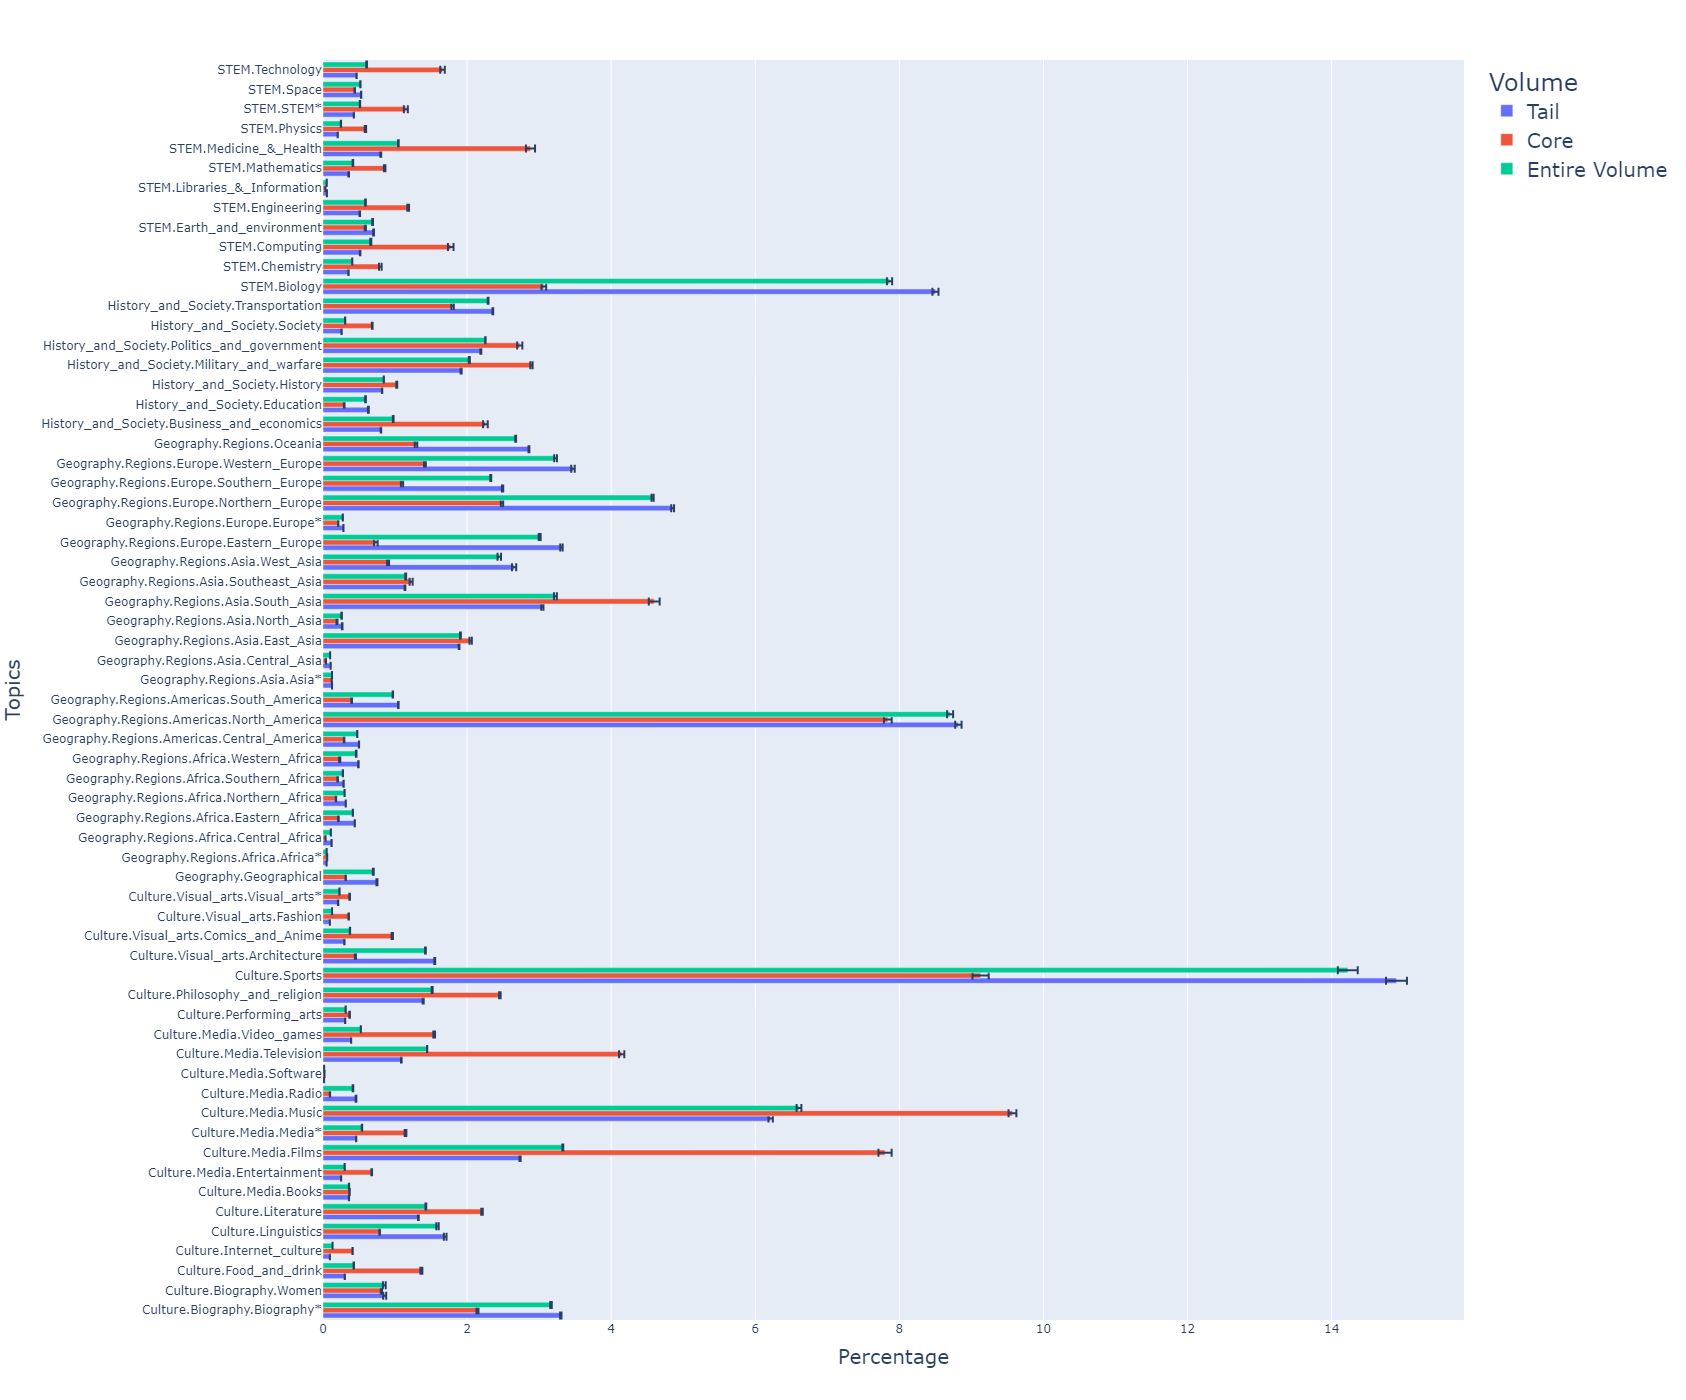

In [61]:
fig = px.bar(df_plot, y='topic', x='mean', error_x='error', color='Volume', orientation='h')
fig.update_layout(height=1400,
                  width=900,
                  barmode='group',
                  xaxis_title=dict(text='Percentage', font=dict(size=20)),
                  yaxis_title=dict(text='Topics', font=dict(size=20)),
                  legend=dict(title='Volume', font=dict(size=20)),
                 )
fig.show()
fig.write_image('../figures_report/data_presentation/topics_en.pdf')

# Common pages stats and topics analysis

## What is the monthly contribution of common pages in the effective size ? (90% of total pageviews ranked by pageviews in descending order)

In [62]:
# COmpute overlap in terms of page ids
df_agg = df_high_volume.groupBy('page_id').agg(count('*').alias('nb_occurrences')).cache()
nb_common = df_agg.where(f'nb_occurrences = "93"').select('page_id').distinct().count()
nb_per_months = df_high_volume.groupBy('date').agg(count('*').alias('nb_pages_monthly'))
prop_tot = nb_per_months.withColumn('prop_month', nb_common / col('nb_pages_monthly') * 100)\
                        .select(avg('prop_month').alias('avg'), stddev('prop_month').alias('std'))\
                        .collect()
print(f" Average : {prop_tot[0]['avg']} +/- {prop_tot[0]['std']}")

 Average : 57.29062599502979 +/- 4.349193224425243


## What is the monthly contribution of common pages in the tail ?

In [63]:
# COmpute overlap in terms of page ids
df_agg_t = df_low_volume.groupBy('page_id').agg(count('*').alias('nb_occurrences')).cache()
nb_common_t = df_agg_t.where(f'nb_occurrences = "93"').select('page_id').distinct().count()
nb_per_month_t = df_low_volume.groupBy('date').agg(count('*').alias('nb_pages_monthly'))
prop_tot_t = nb_per_month_t.withColumn('prop_month', nb_common_t / col('nb_pages_monthly') * 100)\
                        .select(avg('prop_month').alias('avg'), stddev('prop_month').alias('std'))\
                        .collect()
print(f" Average : {prop_tot_t[0]['avg']} +/- {prop_tot_t[0]['std']}")

 Average : 60.834896961472694 +/- 5.702407444396774


## What is the topic distribution of common pages with respect to the entire core / tail ?

In [64]:
# Add page titles - we shouldn't loose any page
df_agg_high = df_high_volume.groupBy('page_id').agg(count('*').alias('nb_occurrences')).where('nb_occurrences = "93"').select('page_id').distinct().cache()
df_high_topics = df_agg_high.join(df_topics_sp.select('page_id', 'topic'), 'page_id').cache()

df_high_topics_unique = df_high_topics.select('page_id', 'topic').distinct()\
                                      .groupBy('topic')\
                                      .agg(count('*').alias('nb_pages'))\
                                      .toPandas()

In [65]:
df_high_topics_unique = df_high_topics_unique.rename(columns={'topic_counts' : 'nb_pages'})
df_high_topics_unique['date'] = 'no_date'

In [66]:
# Add page titles - we shouldn't loose any page
df_agg_low = df_low_volume.groupBy('page_id').agg(count('*').alias('nb_occurrences')).where('nb_occurrences = "93"').select('page_id').distinct().cache()
df_low_topics = df_agg_low.join(df_topics_sp.select('page_id', 'topic'), 'page_id').cache()

df_low_topics_unique = df_low_topics.select('page_id', 'topic').distinct()\
                                      .groupBy('topic')\
                                      .agg(count('*').alias('nb_pages'))\
                                      .toPandas()

In [67]:
df_low_topics_unique = df_low_topics_unique.rename(columns={'topic_counts' : 'nb_pages'})
df_low_topics_unique['date'] = 'no_date'

In [68]:
df_high_topics_unique = make_perc(df_high_topics_unique, t='Common Core').sort_values('topic')
df_low_topics_unique = make_perc(df_low_topics_unique, t='Common Tail').sort_values('topic')

In [69]:
df_plot_low = pd.concat([df_low_volume_top_agg, df_low_topics_unique]).reset_index()
df_plot_high = pd.concat([df_high_volume_top_agg, df_high_topics_unique]).reset_index()
df_plot_low['error'] = df_plot_low['std'] * 1.96 / np.sqrt(93)
df_plot_high['error'] = df_plot_high['std'] * 1.96 / np.sqrt(93)

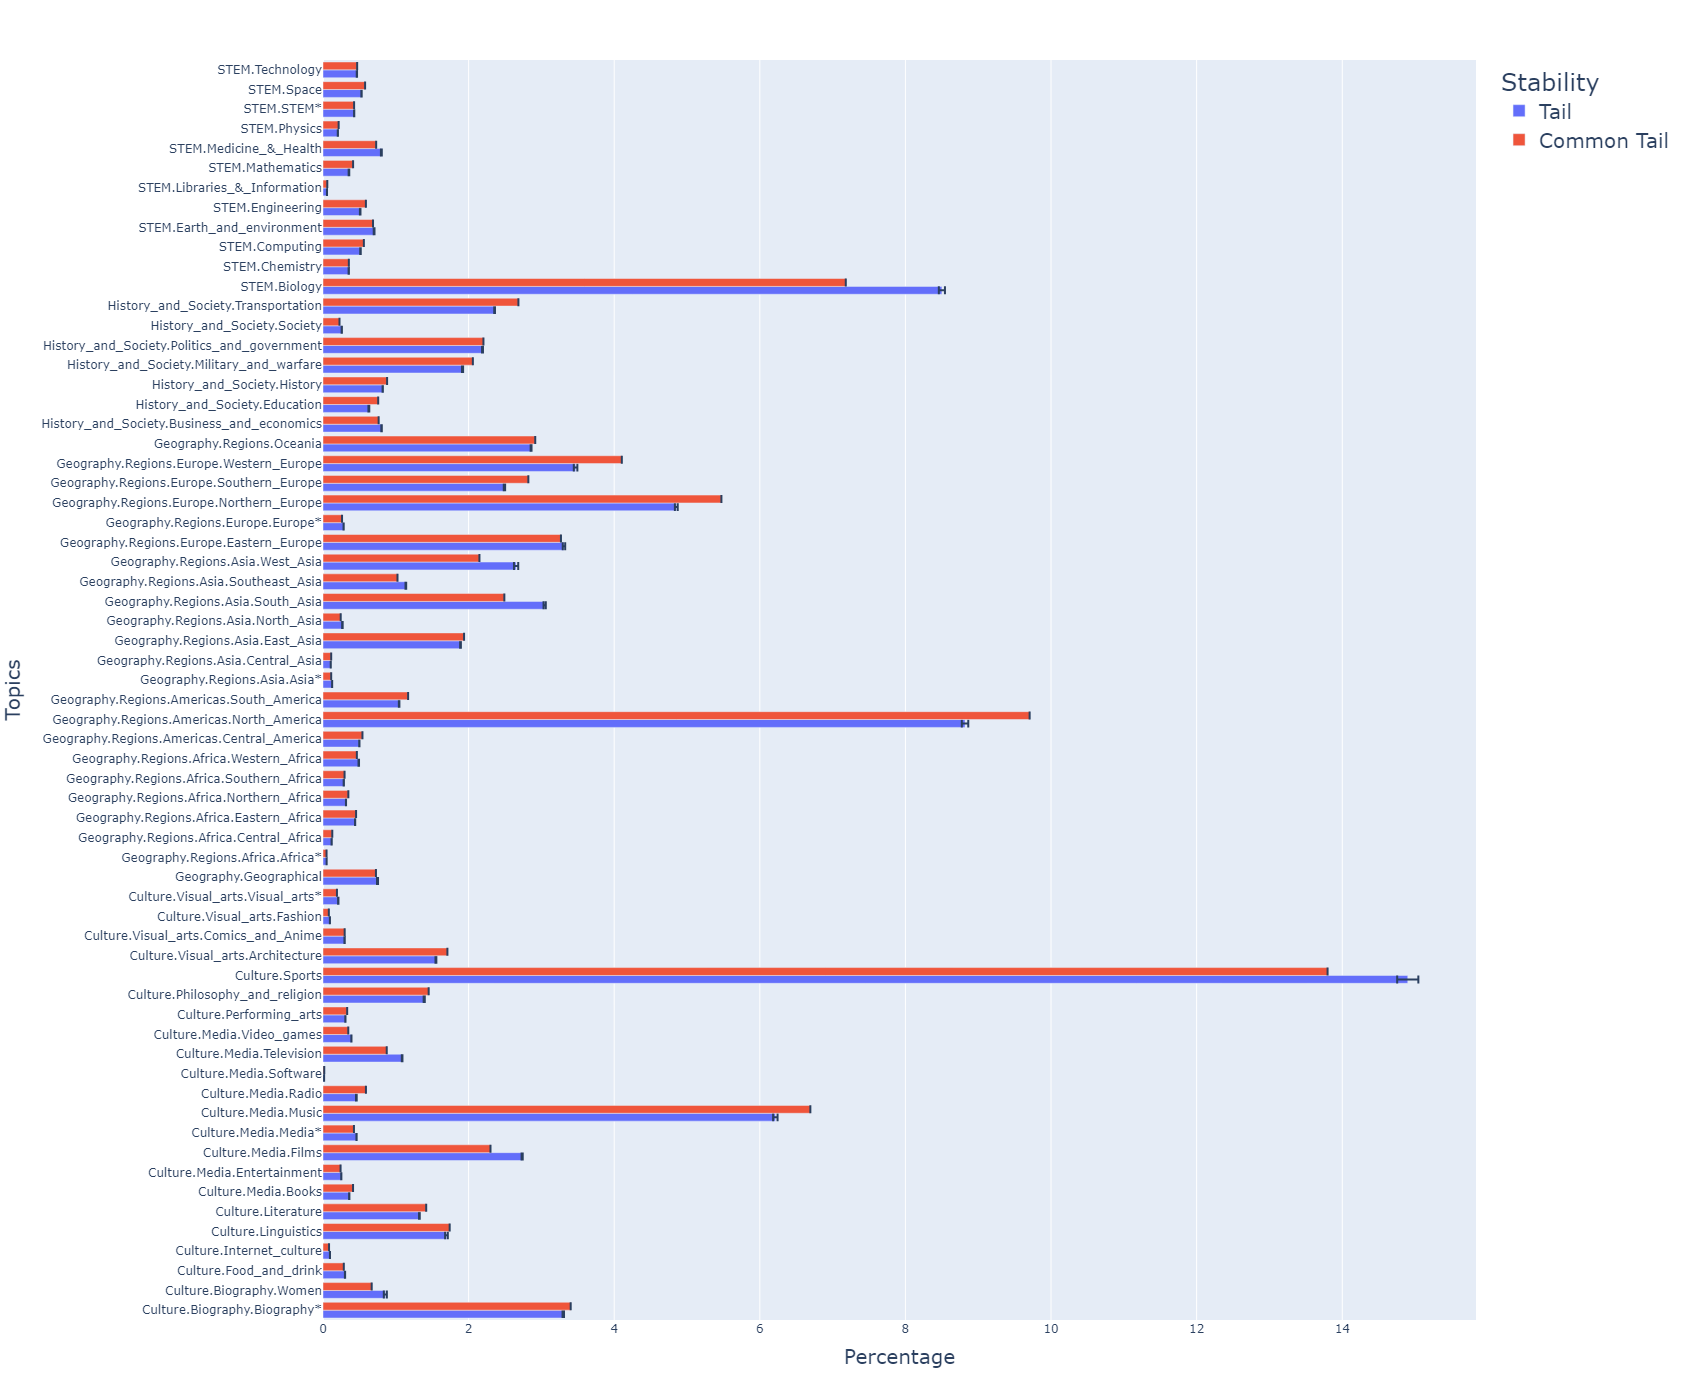

In [70]:
fig = px.bar(df_plot_low, y='topic', x='mean', error_x='error', color='Volume', orientation='h')
fig.update_layout(height=1400,
                  barmode='group',
                  xaxis_title=dict(text='Percentage', font=dict(size=20)),
                  yaxis_title=dict(text='Topics', font=dict(size=20)),
                  legend=dict(title='Stability', font=dict(size=20)),
                 )
fig.show()
fig.write_image('../figures_report/data_presentation/topics_en_tail.pdf')

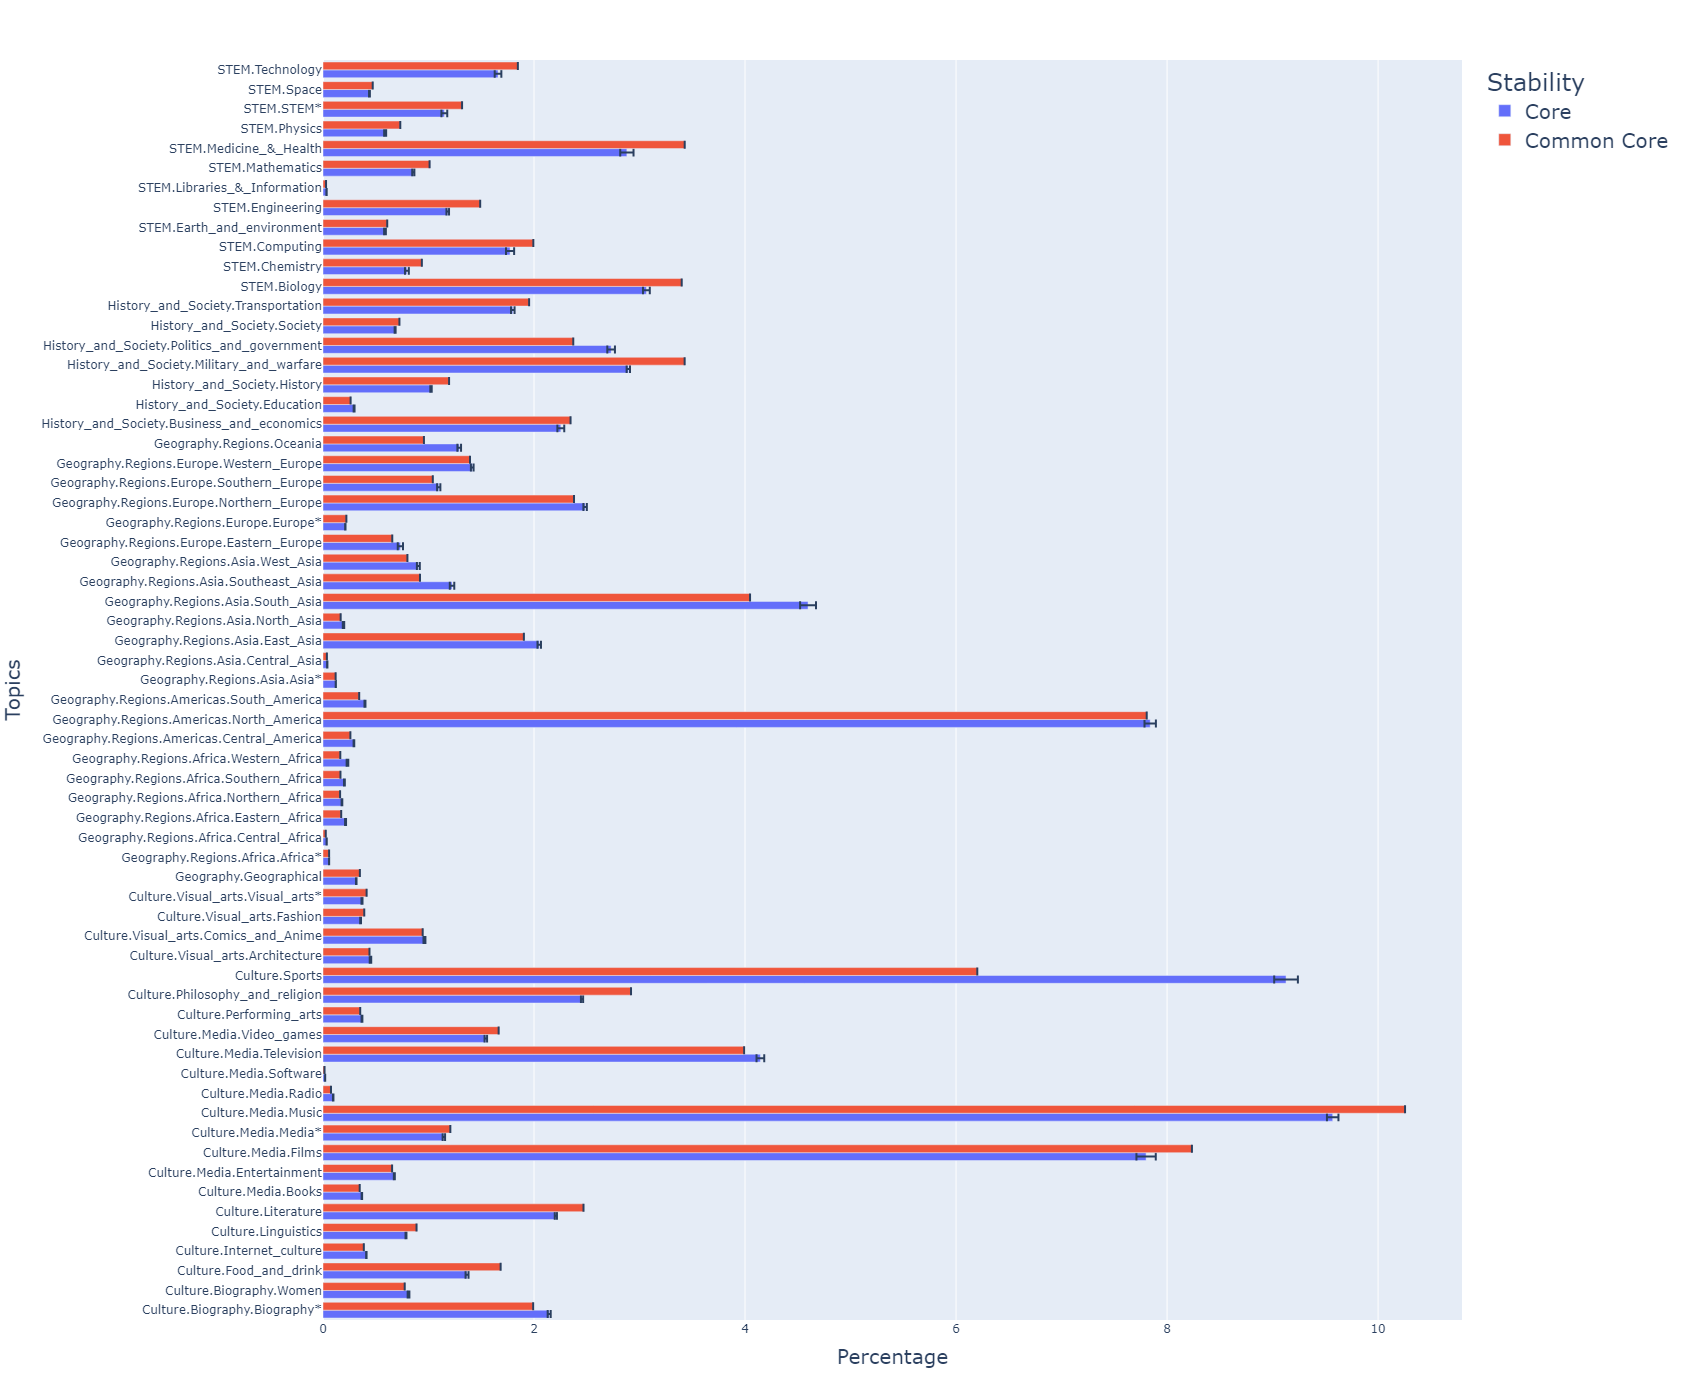

In [71]:
fig = px.bar(df_plot_high, y='topic', x='mean', error_x='error', color='Volume', orientation='h')
fig.update_layout(height=1400,
                  barmode='group',
                  xaxis_title=dict(text='Percentage', font=dict(size=20)),
                  yaxis_title=dict(text='Topics', font=dict(size=20)),
                  legend=dict(title='Stability', font=dict(size=20)),
                 )
fig.show()
fig.write_image('../figures_report/data_presentation/topics_en_core.pdf')

# Draft
Study variance between desktop and mobile views for each page. False positives.

## Code

In [ ]:
df_test = setup_data(['2019'], ['11'], spark).cache()

In [135]:
df_test_filt = filter_data(df_test, "en.wikipedia", ['2019-11']).cache()

In [ ]:
df_agg_f = aggregate_data(df_test_filt, match_ids=False, match_ids_per_access_type=True).cache()

## Analysis

In [186]:
null_deskt = df_agg_f.where(col('desktop_views').isNull()).sort(desc('mobile_views')).cache()

In [187]:
null_mob = df_agg_f.where(col('mobile_views').isNull()).sort(desc('desktop_views')).cache()

In [193]:
df_agg_filt = df_agg_f.where(~col('mobile_views').isNull() & ~col('desktop_views').isNull()).select('page', 'page_id', 'topics', log(col('desktop_views') / col('mobile_views')).alias('views_ratio')).cache()

In [194]:
df_agg_filt.select('page', 'page_id', 'views_ratio').distinct().sort(desc('views_ratio')).show() # More desktop views than mobile views

+--------------------+--------+------------------+
|                page| page_id|       views_ratio|
+--------------------+--------+------------------+
|canal+_(polish_tv...|14424206| 9.007121989469242|
|     gongnyong_ridge|61474032| 8.968778235137956|
|index_of_articles...|  503469|  8.57851001058359|
|chitti_babu_punya...|41434905|  8.47212608804693|
|royal_library_of_...| 2059097| 8.366108639544125|
|     kanal_d_romania|29462128|  8.31115254800169|
|index_of_dos_game...|23761103| 8.017260405641988|
|   k._ravindran_nair|44619315| 7.841492924460013|
|index_of_philosop...|26365840| 7.822891498509467|
|     nebra_(unstrut)|  586406| 7.459577104315676|
|              vincly|13389925|  7.43543801981455|
|timeless_(piolo_p...|31674320| 7.428333194190806|
|index_of_ufology_...|10445372| 7.425059868845837|
|index_of_windows_...|24262374| 7.349984504379459|
|index_of_windows_...|24357253| 7.223700816706778|
|      s._v._ramadoss|43807285| 7.210744595501065|
|simple_mail_trans...|   27675|

In [195]:
df_agg_filt.select('page', 'page_id', 'views_ratio').distinct().sort(asc('views_ratio')).show() # More mobile views than desktop views

+--------------------+--------+-------------------+
|                page| page_id|        views_ratio|
+--------------------+--------+-------------------+
|               maani|49720342|  -8.74080774290356|
|         jan_brokoff|  554111|  -6.97959210260082|
|    birmingham_bulls|14655768|  -6.62774132571425|
|     michael_brokoff|  554146| -6.342814166429555|
|  black_mascara_eyes|39825519|-5.9329080976479585|
|                 typ|24788047|  -5.91716918067121|
|   ferdinand_brokoff|  552543| -5.832768179576761|
|   chintu_television|55647434| -5.734054093925872|
|poker_(disambigua...|18485675| -5.725540478112267|
|cook_islands_(dis...|42370918| -5.716911595594995|
|    sexy,_sexy,_sexy|38590761| -5.550199883137534|
|                whay|18386887| -5.430134791168223|
|     bouchercon_xxxv|34841800|-5.1036380763892195|
|              betika|57726157| -5.067174446750864|
|          hiw_island|19468291| -5.015137962366626|
|                 dif|27012681|  -4.95102289129474|
|blue_film:_

In [204]:
null_deskt_agg = null_deskt.select('page', 'topics_specific_unique', 'mobile_views').distinct().groupBy('topics_specific_unique').agg(count('*').alias('nb_pages'), sum('mobile_views').alias('nb_views')).sort(desc('nb_pages'))

In [208]:
null_deskt_agg.show(truncate=False)

+-------------------------------------------+--------+---------+
|topics_specific_unique                     |nb_pages|nb_views |
+-------------------------------------------+--------+---------+
|culture.sports                             |17718   |960423.0 |
|stem.biology                               |13358   |501247.0 |
|geography.regions.americas.north_america   |12156   |1100459.0|
|history_and_society.politics_and_government|6615    |588277.0 |
|culture.media.music                        |6475    |798946.0 |
|geography.regions.europe.northern_europe   |5736    |461646.0 |
|history_and_society.transportation         |5035    |327112.0 |
|history_and_society.military_and_warfare   |4979    |572232.0 |
|geography.regions.asia.west_asia           |4715    |239361.0 |
|culture.biography.biography*               |4547    |551085.0 |
|geography.regions.europe.eastern_europe    |4140    |140170.0 |
|geography.regions.europe.western_europe    |3816    |274687.0 |
|geography.regions.europe

In [209]:
null_deskt_agg.sort(desc('nb_views')).show(truncate=False)

+-------------------------------------------+--------+---------+
|topics_specific_unique                     |nb_pages|nb_views |
+-------------------------------------------+--------+---------+
|geography.regions.asia.south_asia          |3415    |2268456.0|
|culture.media.films                        |3408    |1825677.0|
|culture.media.television                   |1861    |1147007.0|
|geography.regions.americas.north_america   |12156   |1100459.0|
|culture.sports                             |17718   |960423.0 |
|culture.media.music                        |6475    |798946.0 |
|stem.medicine_&_health                     |862     |717931.0 |
|history_and_society.politics_and_government|6615    |588277.0 |
|history_and_society.military_and_warfare   |4979    |572232.0 |
|culture.biography.biography*               |4547    |551085.0 |
|stem.biology                               |13358   |501247.0 |
|culture.philosophy_and_religion            |2493    |475723.0 |
|culture.literature      

In [207]:
null_mob_agg = null_mob.select('page', 'topics_specific_unique', 'desktop_views').distinct().groupBy('topics_specific_unique').agg(count('*').alias('nb_pages'), sum('desktop_views').alias('nb_views')).sort(desc('nb_pages'))

In [210]:
null_mob_agg.show(truncate=False)

+-------------------------------------------+--------+---------+
|topics_specific_unique                     |nb_pages|nb_views |
+-------------------------------------------+--------+---------+
|stem.biology                               |106708  |1152102.0|
|culture.sports                             |43261   |1233438.0|
|geography.regions.europe.eastern_europe    |27588   |361455.0 |
|geography.regions.asia.west_asia           |20841   |371259.0 |
|geography.regions.americas.north_america   |12681   |892549.0 |
|geography.regions.europe.northern_europe   |10288   |415462.0 |
|geography.regions.europe.western_europe    |9993    |294357.0 |
|geography.regions.europe.southern_europe   |6709    |252369.0 |
|culture.biography.biography*               |6362    |317207.0 |
|history_and_society.politics_and_government|6246    |489001.0 |
|geography.regions.oceania                  |6231    |374924.0 |
|geography.geographical                     |5942    |75340.0  |
|geography.regions.asia.s

In [211]:
null_mob_agg.sort(desc('nb_views')).show(truncate=False)

+-------------------------------------------+--------+---------+
|topics_specific_unique                     |nb_pages|nb_views |
+-------------------------------------------+--------+---------+
|geography.regions.asia.south_asia          |5271    |1754315.0|
|culture.media.films                        |2398    |1718288.0|
|culture.sports                             |43261   |1233438.0|
|stem.biology                               |106708  |1152102.0|
|geography.regions.americas.north_america   |12681   |892549.0 |
|culture.media.television                   |1021    |520098.0 |
|history_and_society.politics_and_government|6246    |489001.0 |
|stem.computing                             |426     |472602.0 |
|culture.media.music                        |3915    |435761.0 |
|history_and_society.military_and_warfare   |3079    |427546.0 |
|stem.mathematics                           |276     |420867.0 |
|geography.regions.europe.northern_europe   |10288   |415462.0 |
|history_and_society.busi